In [23]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc, rcParams
import seaborn as sns
import glob
from sklearn.model_selection import train_test_split
import lightgbm
import datetime
import math
from scipy import stats
import warnings
from itertools import chain, repeat
from tqdm.notebook import tqdm

warnings.filterwarnings('ignore')

plt.style.use('ggplot')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
rcParams['figure.figsize'] = (16, 8)
rc('font', family='AppleGothic')

In [24]:
tr_base_path = './data/train'
te_base_path = './data/test'
submission_path = './submission'
infer_path = './inferencedata'
train_path = './trainingdata'
cv_lb_path = './cv_lb_path'

In [25]:
train = pd.read_csv(os.path.join(tr_base_path,'train.csv'))
submission = pd.read_csv('./data/sample_submission.csv')
# 파일명 불러오는 것: os.listdir과 다른점은 경로를 그대로 붙여서 불러와줌
# test_files = glob.glob('./data/test/*.csv')

# test load 
t_test = []

for i in range(81):
    file_path = './data/test/' + str(i) + '.csv'
    temp = pd.read_csv(file_path)
    t_test.append(temp)
    
test = pd.concat(t_test)
df_test = test.copy()

# pre-processing

## Day1, Day2 predict + Day2, Day3 predict

In [26]:
def base_preprocess(data, n, n2) : 
    
    # 원래 방법대로 한다면, 마지막 48개행은 target2에 대해 미지의 값을 가진게 아닌가?
    # step1 : 하루 뒤, 이틀 뒤 target 값 가져오기 
    data['1day_after_target'] = data.shift(n)['TARGET']
    data['2day_after_target'] = data.shift(n2)['TARGET']
    
    # step2 : 7일간의 segment를 할당하여 예측을 진행 
    
    data = data.dropna(axis=0)
    
    return(data)

In [27]:
df_train = base_preprocess(train, -48, -96)
df_train_day23 = base_preprocess(train, -96, -144)

## Day3, Day4 predict

# EDA

## train/test distribution

In [26]:
# train, test distribution 체크
# 체크해본 결과 특정 변수들에서 분포가 다른 부분들이 존재

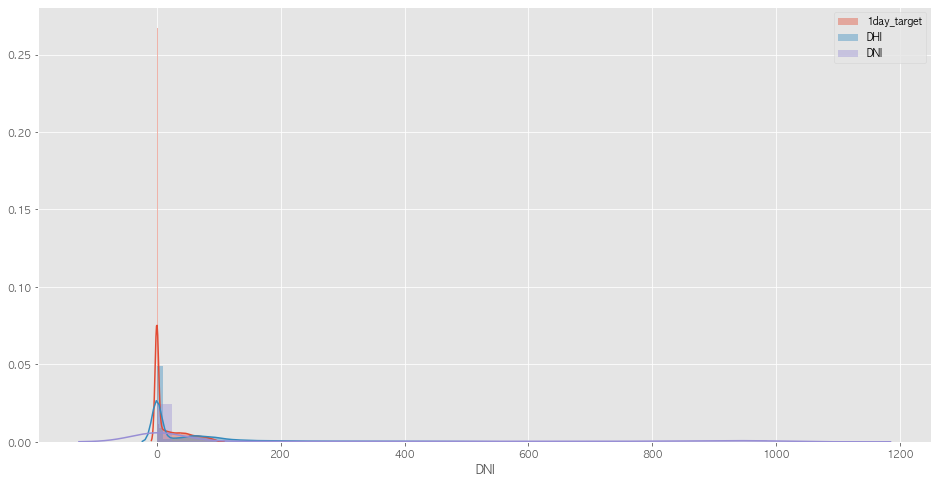

In [17]:
sns.distplot(df_train['1day_after_target'], label = '1day_target')
# sns.distplot(df_train['T'], label = 'T')
sns.distplot(df_train['DHI'], label = 'DHI')
sns.distplot(df_train['DNI'], label = 'DNI')
plt.legend()

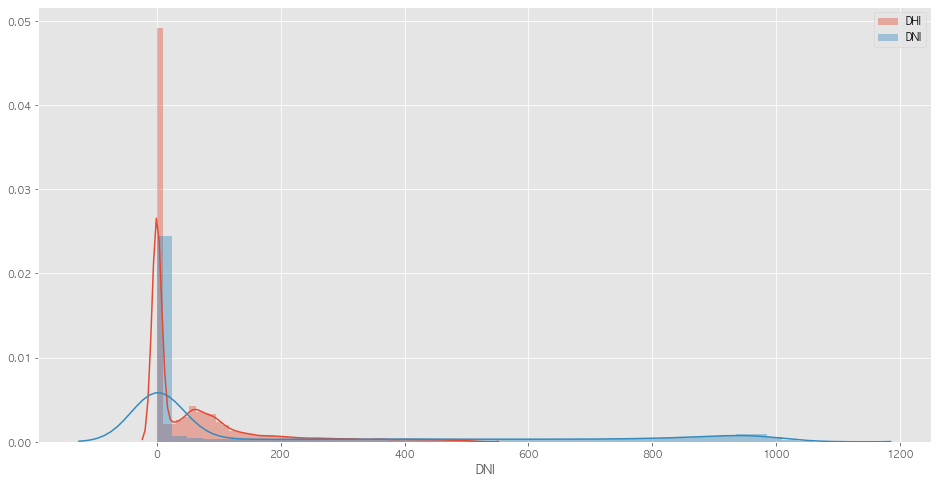

In [18]:
sns.distplot(df_train['DHI'], label = 'DHI')
sns.distplot(df_train['DNI'], label = 'DNI')
plt.legend()

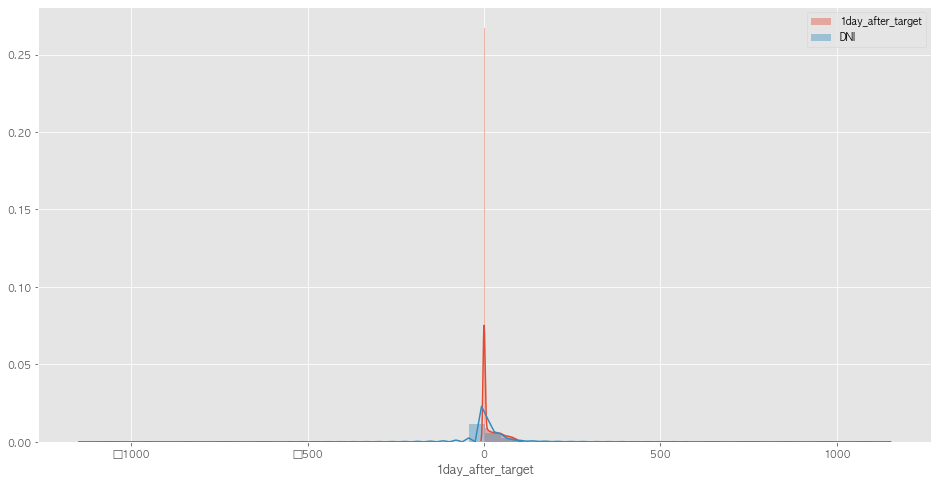

In [23]:
sns.distplot(df_train['1day_after_target'], label = '1day_after_target')
sns.distplot(((df_train['DNI'] + df_train['DHI'])/df_train['T']).replace(np.Inf,0), label = 'DNI')
plt.legend()

In [21]:
df_train[df_train['DHI'] == 0]['1day_after_target'].value_counts()

0    26600
Name: DHI, dtype: int64

In [26]:
df_train.head()

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET,1day_after_target,2day_after_target,DNI_label
0,0,0,0,0,0,1.5,69.08,-12,0.0,0.0,0.0,0
1,0,0,30,0,0,1.5,69.06,-12,0.0,0.0,0.0,0
2,0,1,0,0,0,1.6,71.78,-12,0.0,0.0,0.0,0
3,0,1,30,0,0,1.6,71.75,-12,0.0,0.0,0.0,0
4,0,2,0,0,0,1.6,75.20,-12,0.0,0.0,0.0,0


In [52]:
df_temp = df_train.groupby(
    ['Hour','Minute']
)['DHI'].count().reset_index()
df_temp['label'] = np.linspace(0,24,49)[:-1]

df_train_temp = df_train.copy()

df_train_temp = pd.merge(
    df_train_temp, 
    df_temp.drop(columns = 'DHI'), 
    on = ['Hour','Minute'],
    how = 'left'
)
plt_df = df_train_temp.groupby('label')['TARGET'].mean().reset_index()

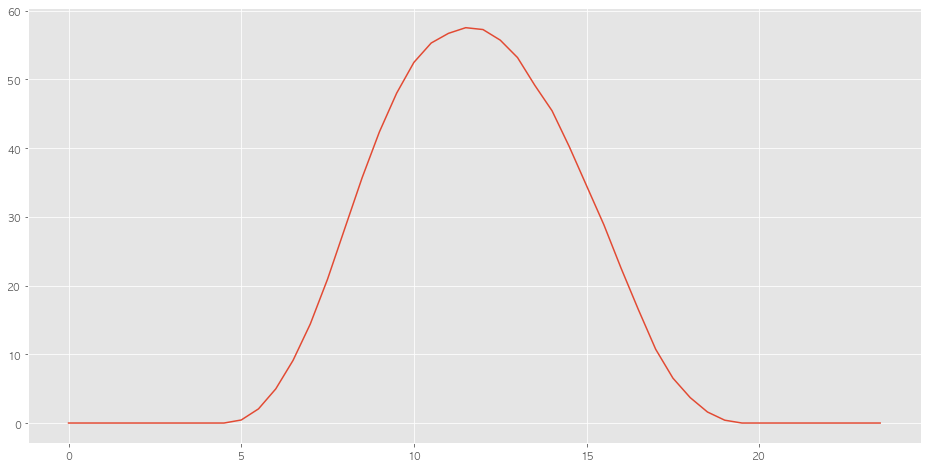

In [53]:
plt.plot(plt_df['label'], plt_df['TARGET'])

## correlation / heatmap

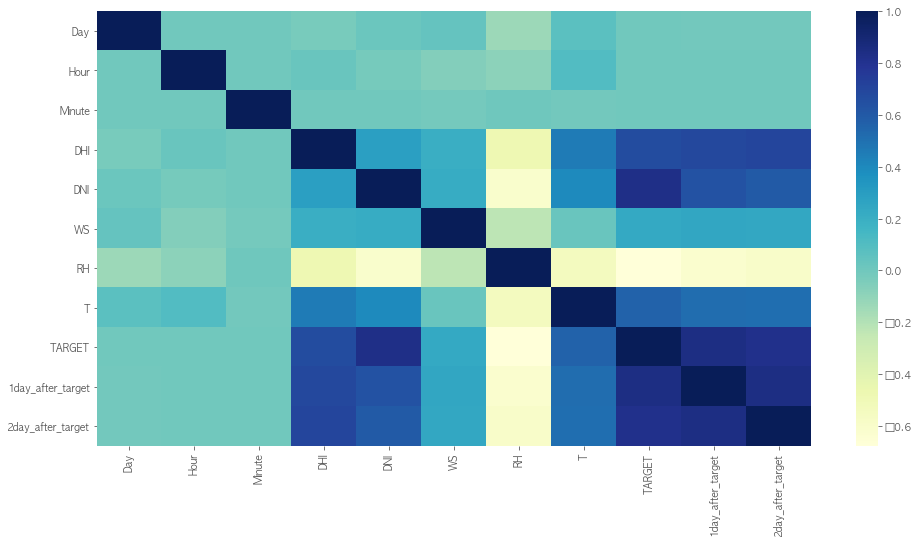

In [9]:
sns.heatmap(df_train.corr(), cmap='YlGnBu')

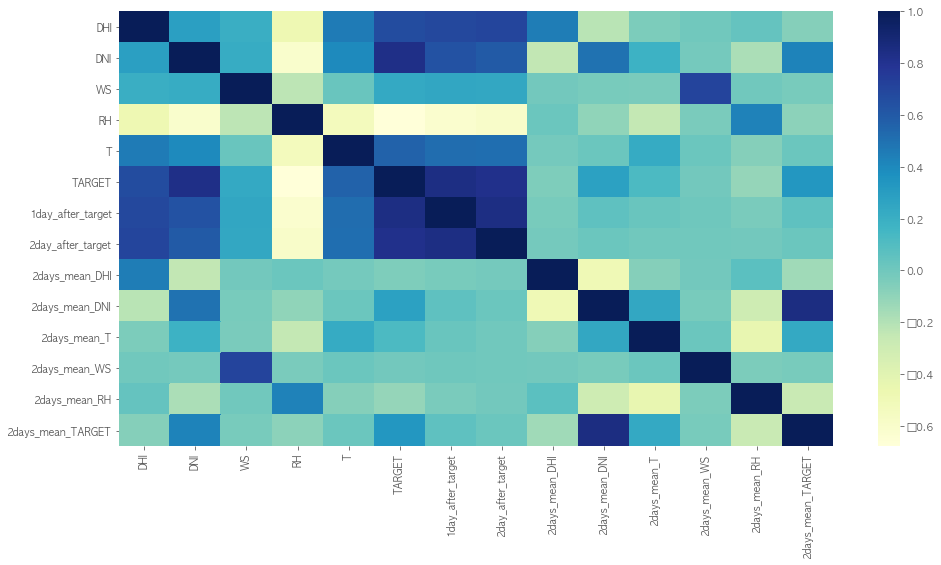

In [164]:
sns.heatmap(df_train.corr(), cmap='YlGnBu')

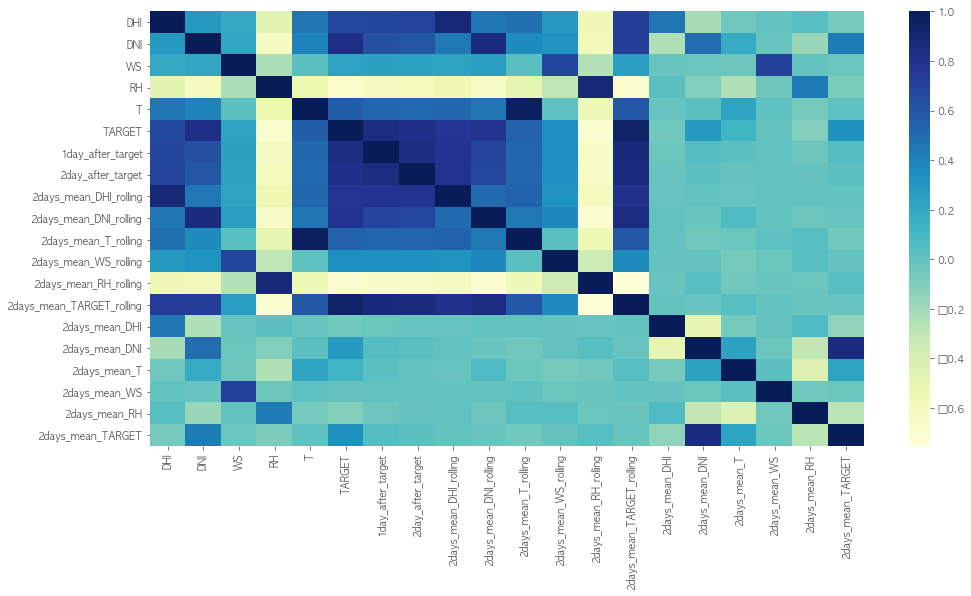

In [173]:
sns.heatmap(df_train.corr(), cmap='YlGnBu')

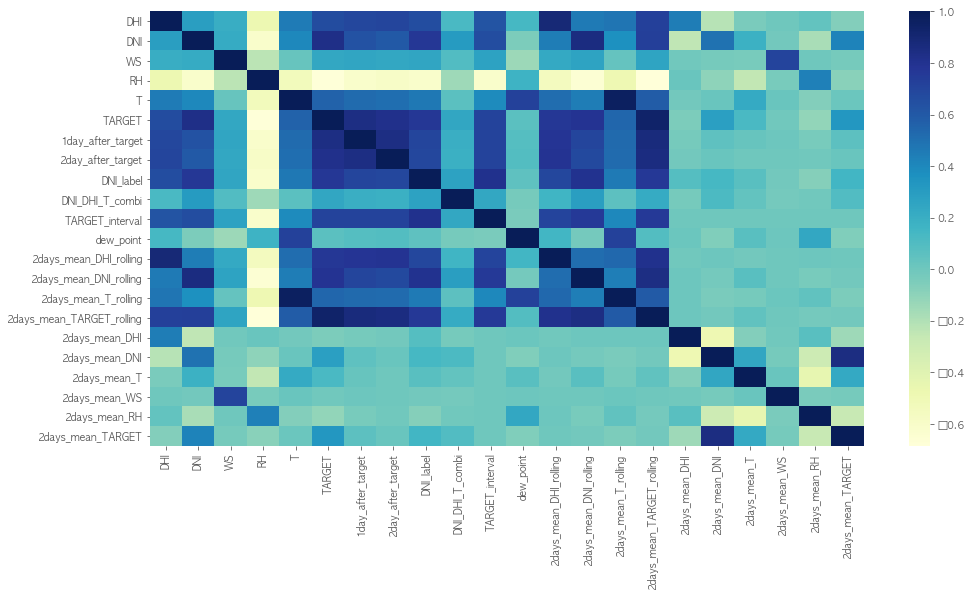

In [81]:
sns.heatmap(df_train.corr(), cmap='YlGnBu')

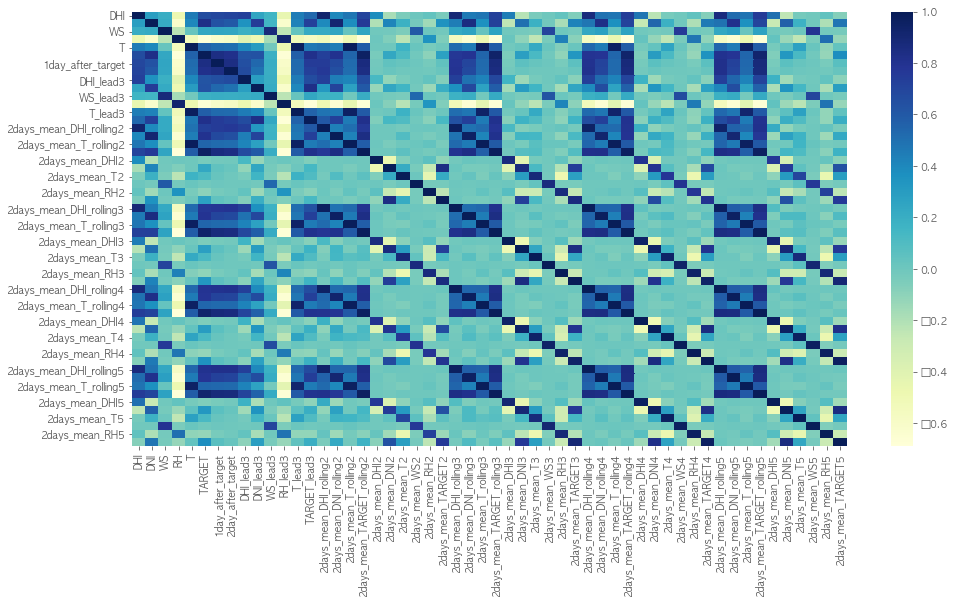

In [305]:
sns.heatmap(df_train.corr(), cmap='YlGnBu')

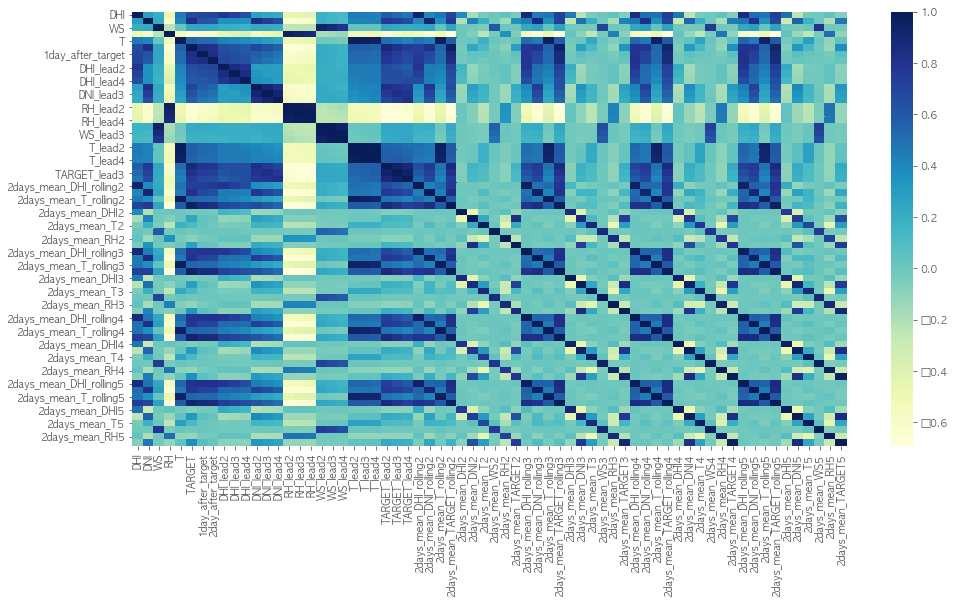

In [407]:
sns.heatmap(df_train.corr(), cmap='YlGnBu')

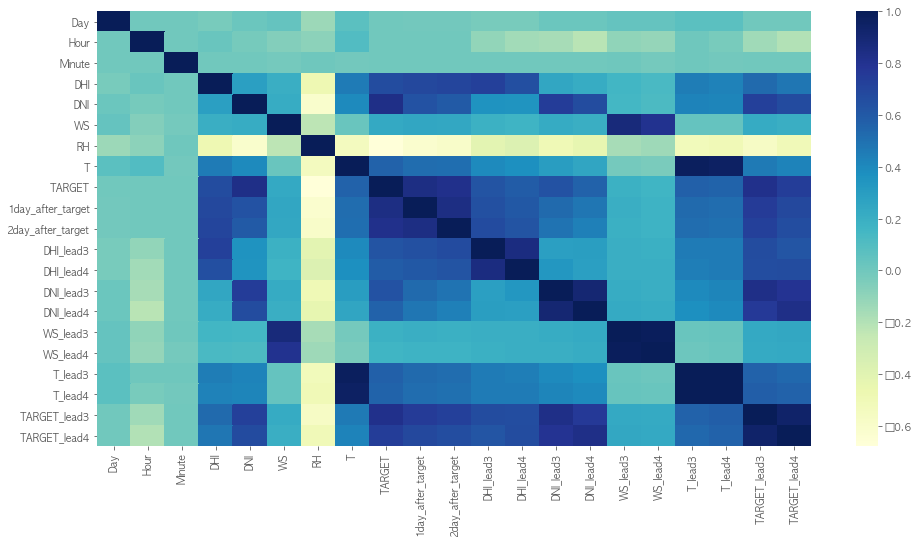

In [12]:
sns.heatmap(df_train.corr(), cmap='YlGnBu')

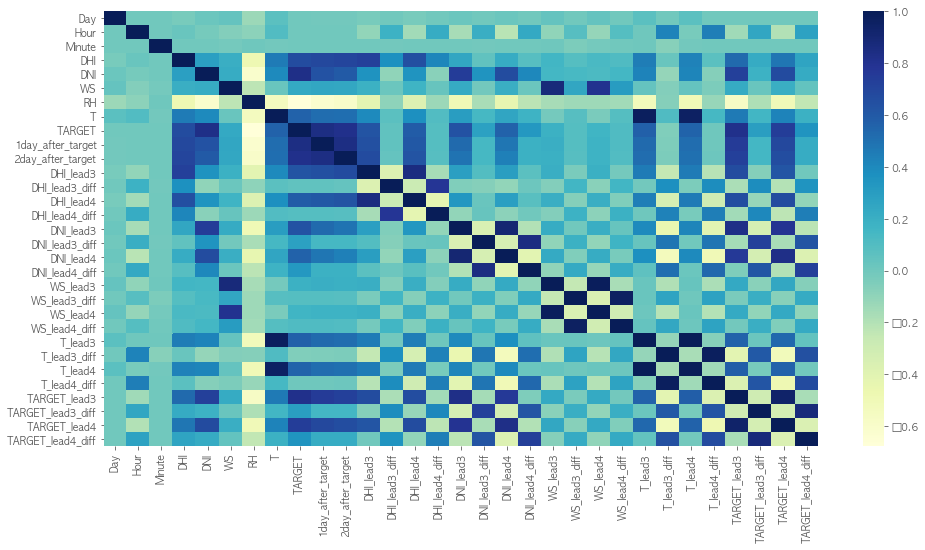

In [22]:
sns.heatmap(df_train.corr(), cmap='YlGnBu')

## outlier check

In [ ]:
def 

In [ ]:
# 계절과 관련한 이상치 파악

# Feature Engineering

## 변수 생성 시도(아직 테스트X)

In [28]:

# Lead features
def lead_feature(df, col_ls, lag_ls):
    lead_agg_df = df.groupby(['Hour','Minute'])[['DHI','DNI','WS','RH','T','TARGET']].mean().reset_index()

    for item in col_ls:
        for lag_n in lag_ls:
            lead = lead_agg_df.iloc[:lag_n][item]

            df[f'{item}_lead{lag_n}'] = df[item].shift(-1 * lag_n).dropna().tolist() + lead.tolist()
            df[f'{item}_lead{lag_n}_diff'] = df[item] - pd.Series((df[item].shift(-1 * lag_n).dropna().tolist() + lead.tolist()))
    return df

# Lag features
def lead_feature_test(df, col_ls, lag_ls):
    label_list = []

    for i in range(81) : 
        label_list.append([i]*336)

    label_list = [item for sublist in label_list for item in sublist]

    df['label'] = label_list 

    test_dataset = []

    
    for label_num in tqdm(df.label.unique()): 

        df2 = df[df['label']==label_num]
        
        lead_agg_df = df2.groupby(['Hour','Minute'])[['DHI','DNI','WS','RH','T','TARGET']].mean().reset_index()
        
        for item in col_ls:
            for lag_n in lag_ls:
                lead = lead_agg_df.iloc[:lag_n][item]

                df2[f'{item}_lead{lag_n}'] = df2[item].shift(-1 * lag_n).dropna().tolist() + lead.tolist()
                df2[f'{item}_lead{lag_n}_diff'] = df2[item] - pd.Series((df2[item].shift(-1 * lag_n).dropna().tolist() + lead.tolist()))
                
        test_dataset.append(df2)
        print(temp.shape)
        
    df_test = pd.concat(test_dataset).reset_index().sort_values(['label','index'])
    df_test = df_test.drop(['index'],axis=1).reset_index(drop=True) 
    return df_test


# # Lag each hour split data
# def lead_feature_each_time(df, col_ls, lag_ls):
    
#     hour_lists = []

#     numbers = list(np.arange(0,24,1))
#     n_list = [2]*24

#     hours_range = list(chain.from_iterable((repeat(number, n) for (number, n) in zip(numbers, n_list))))

#     for (hours,minutes) in zip(hours_range,list(np.arange(0,31,30))*30) : 
#         # Day를 제거하고 Hour, Minute끼리 짝지어서 데이터를 만든다
#         hour_lists.append(df[(df['Hour']==hours) & (df['Minute']==minutes)])

#     # 만든 데이터만을 이용하여 이동평균 데이터 추출
#     for num in tqdm(range(len(hour_lists))):
#         for item in col_ls:
#             for lag_n in lag_ls:
#                 hour_lists[num][f'{item}_lead{lag_n}'] = hour_lists[num][item].shift(-1 *lag_n)
        
#     df_train = pd.concat(hour_lists).sort_index() 

#     return df_train

In [29]:
col_ls = ['DHI', 'DNI', 'WS', 'T', 'TARGET']
df_train = lead_feature(
    df_train,
    col_ls,
    [3,4,5]
)

df_test = lead_feature_test(
    df_test,
    col_ls,
    [3,4,5]
)

df_train_day23 = lead_feature(
    df_train_day23,
    col_ls,
    [3,4,5]
)

(336, 9)
(336, 9)
(336, 9)
(336, 9)
(336, 9)
(336, 9)
(336, 9)
(336, 9)
(336, 9)
(336, 9)
(336, 9)
(336, 9)
(336, 9)
(336, 9)
(336, 9)
(336, 9)
(336, 9)
(336, 9)
(336, 9)
(336, 9)
(336, 9)
(336, 9)
(336, 9)
(336, 9)
(336, 9)
(336, 9)
(336, 9)
(336, 9)
(336, 9)
(336, 9)
(336, 9)
(336, 9)
(336, 9)
(336, 9)
(336, 9)
(336, 9)
(336, 9)
(336, 9)
(336, 9)
(336, 9)
(336, 9)
(336, 9)
(336, 9)
(336, 9)
(336, 9)
(336, 9)
(336, 9)
(336, 9)
(336, 9)
(336, 9)
(336, 9)
(336, 9)
(336, 9)
(336, 9)
(336, 9)
(336, 9)
(336, 9)
(336, 9)
(336, 9)
(336, 9)
(336, 9)
(336, 9)
(336, 9)
(336, 9)
(336, 9)
(336, 9)
(336, 9)
(336, 9)
(336, 9)
(336, 9)
(336, 9)
(336, 9)
(336, 9)
(336, 9)
(336, 9)
(336, 9)
(336, 9)
(336, 9)
(336, 9)
(336, 9)
(336, 9)



In [ ]:
# Target mean encoding

In [ ]:
# expanding window
# 위의 변수생성법에 대한 리서치
# rolling과 어떻게 다르지?

In [ ]:
# aggregate function
# Hour

## 성능 상승 변수들

In [30]:
from tqdm.notebook import tqdm
# 필령이형 feature
# N=3 이동평균 diff 데이터
def train_2day_variable(df_train, rolling_num_list, drop_col) : 
    
    hour_lists = []

    numbers = list(np.arange(0,24,1))
    n_list = [2]*24

    hours_range = list(chain.from_iterable((repeat(number, n) for (number, n) in zip(numbers, n_list))))

    for (hours,minutes) in zip(hours_range,list(np.arange(0,31,30))*30) : 
        # Day를 제거하고 Hour, Minute끼리 짝지어서 데이터를 만든다
        hour_lists.append(df_train[(df_train['Hour']==hours) & (df_train['Minute']==minutes)])

    # 만든 데이터만을 이용하여 이동평균 데이터 추출
    for num in tqdm(range(len(hour_lists))): 
        for rolling_num in rolling_num_list:

            hour_lists[num]['2days_mean_DHI_rolling{}'.format(rolling_num)] = hour_lists[num]['DHI'].rolling(rolling_num).mean()
            hour_lists[num]['2days_mean_DNI_rolling{}'.format(rolling_num)] = hour_lists[num]['DNI'].rolling(rolling_num).mean()
            hour_lists[num]['2days_mean_T_rolling{}'.format(rolling_num)] = hour_lists[num]['T'].rolling(rolling_num).mean()
            hour_lists[num]['2days_mean_WS_rolling{}'.format(rolling_num)] = hour_lists[num]['WS'].rolling(rolling_num).mean()
            hour_lists[num]['2days_mean_RH_rolling{}'.format(rolling_num)] = hour_lists[num]['RH'].rolling(rolling_num).mean()
            hour_lists[num]['2days_mean_TARGET_rolling{}'.format(rolling_num)] = hour_lists[num]['TARGET'].rolling(rolling_num).mean()

            # 기존 변수 - 이동평균 차이값 추출
            hour_lists[num]['2days_mean_DHI{}'.format(rolling_num)] = hour_lists[num]['DHI']-hour_lists[num]['2days_mean_DHI_rolling{}'.format(rolling_num)]
            hour_lists[num]['2days_mean_DNI{}'.format(rolling_num)] = hour_lists[num]['DNI']-hour_lists[num]['2days_mean_DNI_rolling{}'.format(rolling_num)]
            hour_lists[num]['2days_mean_T{}'.format(rolling_num)] = hour_lists[num]['T']-hour_lists[num]['2days_mean_T_rolling{}'.format(rolling_num)]
            hour_lists[num]['2days_mean_WS{}'.format(rolling_num)] = hour_lists[num]['WS']-hour_lists[num]['2days_mean_WS_rolling{}'.format(rolling_num)]
            hour_lists[num]['2days_mean_RH{}'.format(rolling_num)] = hour_lists[num]['RH']-hour_lists[num]['2days_mean_RH_rolling{}'.format(rolling_num)]
            hour_lists[num]['2days_mean_TARGET{}'.format(rolling_num)] = hour_lists[num]['TARGET']-hour_lists[num]['2days_mean_TARGET_rolling{}'.format(rolling_num)]

    df_train = pd.concat(hour_lists).sort_index() 
    df_train.drop(columns = drop_col, inplace = True)
    return(df_train)

def test_2day_variable(df_test, rolling_num_list, drop_col) : 
    
    label_list = []

    for i in range(81) : 
        label_list.append([i]*336)

    label_list = [item for sublist in label_list for item in sublist]

    df_test['label'] = label_list 

    test_dataset = []

    for label_num in tqdm(df_test.label.unique()): 

        hour_lists = []
        numbers = list(np.arange(0,24,1))
        n_list = [2]*24
        df_test2 = df_test[df_test['label']==label_num]

        hours_range = list(chain.from_iterable((repeat(number, n) for (number, n) in zip(numbers, n_list))))

        for (hours,minutes) in zip(hours_range,list(np.arange(0,31,30))*30) : 
            hour_lists.append(df_test2[(df_test2['Hour']==hours) & (df_test2['Minute']==minutes)])

        for num in (range(len(hour_lists))): 
            for rolling_num in rolling_num_list:

                hour_lists[num]['2days_mean_DHI_rolling{}'.format(rolling_num)] = hour_lists[num]['DHI'].rolling(rolling_num).mean()
                hour_lists[num]['2days_mean_DNI_rolling{}'.format(rolling_num)] = hour_lists[num]['DNI'].rolling(rolling_num).mean()
                hour_lists[num]['2days_mean_T_rolling{}'.format(rolling_num)] = hour_lists[num]['T'].rolling(rolling_num).mean()
                hour_lists[num]['2days_mean_WS_rolling{}'.format(rolling_num)] = hour_lists[num]['WS'].rolling(rolling_num).mean()
                hour_lists[num]['2days_mean_RH_rolling{}'.format(rolling_num)] = hour_lists[num]['RH'].rolling(rolling_num).mean()
                hour_lists[num]['2days_mean_TARGET_rolling{}'.format(rolling_num)] = hour_lists[num]['TARGET'].rolling(rolling_num).mean()

                # 기존 변수 - 이동평균 차이값 추출
                hour_lists[num]['2days_mean_DHI{}'.format(rolling_num)] = hour_lists[num]['DHI']-hour_lists[num]['2days_mean_DHI_rolling{}'.format(rolling_num)]
                hour_lists[num]['2days_mean_DNI{}'.format(rolling_num)] = hour_lists[num]['DNI']-hour_lists[num]['2days_mean_DNI_rolling{}'.format(rolling_num)]
                hour_lists[num]['2days_mean_T{}'.format(rolling_num)] = hour_lists[num]['T']-hour_lists[num]['2days_mean_T_rolling{}'.format(rolling_num)]
                hour_lists[num]['2days_mean_WS{}'.format(rolling_num)] = hour_lists[num]['WS']-hour_lists[num]['2days_mean_WS_rolling{}'.format(rolling_num)]
                hour_lists[num]['2days_mean_RH{}'.format(rolling_num)] = hour_lists[num]['RH']-hour_lists[num]['2days_mean_RH_rolling{}'.format(rolling_num)]
                hour_lists[num]['2days_mean_TARGET{}'.format(rolling_num)] = hour_lists[num]['TARGET']-hour_lists[num]['2days_mean_TARGET_rolling{}'.format(rolling_num)]

        temp = pd.concat(hour_lists)
        test_dataset.append(temp)
        print(temp.shape)
    df_test = pd.concat(test_dataset).reset_index().sort_values(['label','index'])
    df_test = df_test.drop(['index'],axis=1).reset_index(drop=True) 
    df_test.drop(columns = drop_col, inplace = True)
    return(df_test)

In [416]:
# # 시간-분을 묶지 않은 데이터로 2times rolling
# # N=3 이동평균 diff 데이터
# def train_2day_variable(df_train, rolling_num, drop_col) : 
    
# #     hour_lists = []

# #     numbers = list(np.arange(0,24,1))
# #     n_list = [2]*24

# #     hours_range = list(chain.from_iterable((repeat(number, n) for (number, n) in zip(numbers, n_list))))

# #     for (hours,minutes) in zip(hours_range,list(np.arange(0,31,30))*30) : 
# #         # Day를 제거하고 Hour, Minute끼리 짝지어서 데이터를 만든다
# #         hour_lists.append(df_train[(df_train['Hour']==hours) & (df_train['Minute']==minutes)])

# #     # 만든 데이터만을 이용하여 이동평균 데이터 추출
# #     for num in range(len(hour_lists)) : 


#     df_train['2days_mean_DHI_rolling'] = df_train['DHI'].rolling(rolling_num).mean()
#     df_train['2days_mean_DNI_rolling'] = df_train['DNI'].rolling(rolling_num).mean()
#     df_train['2days_mean_T_rolling'] = df_train['T'].rolling(rolling_num).mean()
#     df_train['2days_mean_WS_rolling'] = df_train['WS'].rolling(rolling_num).mean()
#     df_train['2days_mean_RH_rolling'] = df_train['RH'].rolling(rolling_num).mean()
#     df_train['2days_mean_TARGET_rolling'] = df_train['TARGET'].rolling(rolling_num).mean()

#     # 기존 변수 - 이동평균 차이값 추출
#     df_train['2days_mean_DHI'] = df_train['DHI']-df_train['2days_mean_DHI_rolling']
#     df_train['2days_mean_DNI'] = df_train['DNI']-df_train['2days_mean_DNI_rolling']
#     df_train['2days_mean_T'] = df_train['T']-df_train['2days_mean_T_rolling']
#     df_train['2days_mean_WS'] = df_train['WS']-df_train['2days_mean_WS_rolling']
#     df_train['2days_mean_RH'] = df_train['RH']-df_train['2days_mean_RH_rolling']
#     df_train['2days_mean_TARGET'] = df_train['TARGET']-df_train['2days_mean_TARGET_rolling']

#     df_train.index = range(len(df_train)) 
#     df_train.drop(columns = drop_col, inplace = True)
#     return(df_train)

# def test_2day_variable(df_test, rolling_num, drop_col) : 
    
#     label_list = []

#     for i in range(81) : 
#         label_list.append([i]*336)

#     label_list = [item for sublist in label_list for item in sublist]

#     df_test['label'] = label_list 

#     test_dataset = []

#     for label_num in df_test.label.unique() : 

#         hour_lists = []
#         numbers = list(np.arange(0,24,1))
#         n_list = [2]*24
#         df_test2 = df_test[df_test['label']==label_num]

#         df_test2['2days_mean_DHI_rolling'] = df_test2['DHI'].rolling(rolling_num).mean()
#         df_test2['2days_mean_DNI_rolling'] = df_test2['DNI'].rolling(rolling_num).mean()
#         df_test2['2days_mean_T_rolling'] = df_test2['T'].rolling(rolling_num).mean()
#         df_test2['2days_mean_WS_rolling'] = df_test2['WS'].rolling(rolling_num).mean()
#         df_test2['2days_mean_RH_rolling'] = df_test2['RH'].rolling(rolling_num).mean()
#         df_test2['2days_mean_TARGET_rolling'] = df_test2['TARGET'].rolling(rolling_num).mean()

#         # 기존 변수 - 이동평균 차이값 추출
#         df_test2['2days_mean_DHI'] = df_test2['DHI']-df_test2['2days_mean_DHI_rolling']
#         df_test2['2days_mean_DNI'] = df_test2['DNI']-df_test2['2days_mean_DNI_rolling']
#         df_test2['2days_mean_T'] = df_test2['T']-df_test2['2days_mean_T_rolling']
#         df_test2['2days_mean_WS'] = df_test2['WS']-df_test2['2days_mean_WS_rolling']
#         df_test2['2days_mean_RH'] = df_test2['RH']-df_test2['2days_mean_RH_rolling']
#         df_test2['2days_mean_TARGET'] = df_test2['TARGET']-df_test2['2days_mean_TARGET_rolling']

#         test_dataset.append(df_test2)
        
#     df_test = pd.concat(test_dataset).reset_index().sort_values(['label','index'])
#     df_test = df_test.drop(['index'],axis=1).reset_index(drop=True) 
    
#     df_test.drop(columns = drop_col, inplace = True)
#     return(df_test)

In [31]:
from itertools import chain
drop_cols = list(chain(*[['2days_mean_WS_rolling{}'.format(c), '2days_mean_RH_rolling{}'.format(c)] for c in ([2,3,4,5])]))
df_train = train_2day_variable(
    df_train, 
    rolling_num_list=[2,3,4,5],
    drop_col = drop_cols
)
df_train_day23 = train_2day_variable(
    df_train_day23, 
    rolling_num_list=[2,3,4,5], 
    drop_col = drop_cols
)
df_test = test_2day_variable(
    df_test, 
    rolling_num_list=[2,3,4,5],
    drop_col = drop_cols
)

(336, 88)
(336, 88)
(336, 88)
(336, 88)
(336, 88)
(336, 88)
(336, 88)
(336, 88)
(336, 88)
(336, 88)
(336, 88)
(336, 88)
(336, 88)
(336, 88)
(336, 88)
(336, 88)
(336, 88)
(336, 88)
(336, 88)
(336, 88)
(336, 88)
(336, 88)
(336, 88)
(336, 88)
(336, 88)
(336, 88)
(336, 88)
(336, 88)
(336, 88)
(336, 88)
(336, 88)
(336, 88)
(336, 88)
(336, 88)
(336, 88)
(336, 88)
(336, 88)
(336, 88)
(336, 88)
(336, 88)
(336, 88)
(336, 88)
(336, 88)
(336, 88)
(336, 88)
(336, 88)
(336, 88)
(336, 88)
(336, 88)
(336, 88)
(336, 88)
(336, 88)
(336, 88)
(336, 88)
(336, 88)
(336, 88)
(336, 88)
(336, 88)
(336, 88)
(336, 88)
(336, 88)
(336, 88)
(336, 88)
(336, 88)
(336, 88)
(336, 88)
(336, 88)
(336, 88)
(336, 88)
(336, 88)
(336, 88)
(336, 88)
(336, 88)
(336, 88)
(336, 88)
(336, 88)
(336, 88)
(336, 88)
(336, 88)
(336, 88)
(336, 88)



## 성능 저하변수들

In [ ]:
# Lag features
def lag_feature(df, col_ls, lag_ls):
    for item in col_ls:
        for lag_n in lag_ls:
            df[f'{item}_lag{lag_n}'] = df[item].shift(lag_n)
        
            
    return df

# Lag features
def lag_feature_test(df, col_ls, lag_ls):
    label_list = []

    for i in range(81) : 
        label_list.append([i]*336)

    label_list = [item for sublist in label_list for item in sublist]

    df['label'] = label_list 

    test_dataset = []

    for label_num in tqdm(df.label.unique()): 

        df2 = df[df['label']==label_num]
        
        for item in col_ls:
            for lag_n in lag_ls:
                df2[f'{item}_lag{lag_n}'] = df2[item].shift(lag_n)
                
        test_dataset.append(df2)
        print(temp.shape)
        
    df_test = pd.concat(test_dataset).reset_index().sort_values(['label','index'])
    df_test = df_test.drop(['index'],axis=1).reset_index(drop=True) 
    return df_test

# Lag each hour split data
def lag_feature_each_time(df, col_ls, lag_ls):
    
    hour_lists = []

    numbers = list(np.arange(0,24,1))
    n_list = [2]*24

    hours_range = list(chain.from_iterable((repeat(number, n) for (number, n) in zip(numbers, n_list))))

    for (hours,minutes) in zip(hours_range,list(np.arange(0,31,30))*30) : 
        # Day를 제거하고 Hour, Minute끼리 짝지어서 데이터를 만든다
        hour_lists.append(df[(df['Hour']==hours) & (df['Minute']==minutes)])

    # 만든 데이터만을 이용하여 이동평균 데이터 추출
    for num in tqdm(range(len(hour_lists))):
        for item in col_ls:
            for lag_n in lag_ls:
                hour_lists[num][f'{item}_lag{lag_n}'] = hour_lists[num][item].shift(lag_n)
        
    df_train = pd.concat(hour_lists).sort_index() 

    return df_train

# Lag each hour split data
def lag_feature_each_time_test(df, col_ls, lag_ls):
    
    label_list = []

    for i in range(81) : 
        label_list.append([i]*336)

    label_list = [item for sublist in label_list for item in sublist]

    df['label'] = label_list 

    test_dataset = []

    for label_num in tqdm(df.label.unique()): 
        
        hour_lists = []
        numbers = list(np.arange(0,24,1))
        n_list = [2]*24
        df2 = df[df['label']==label_num]
        
        hours_range = list(chain.from_iterable((repeat(number, n) for (number, n) in zip(numbers, n_list))))

        for (hours,minutes) in zip(hours_range,list(np.arange(0,31,30))*30) : 
            # Day를 제거하고 Hour, Minute끼리 짝지어서 데이터를 만든다
            hour_lists.append(df2[(df2['Hour']==hours) & (df2['Minute']==minutes)])

        # 만든 데이터만을 이용하여 이동평균 데이터 추출
        for num in (range(len(hour_lists))):
            for item in col_ls:
                for lag_n in lag_ls:
                    hour_lists[num][f'{item}_lag{lag_n}'] = hour_lists[num][item].shift(lag_n)
        
        temp = pd.concat(hour_lists)
        test_dataset.append(temp)
        print(temp.shape)
        
    df_test = pd.concat(test_dataset).reset_index().sort_values(['label','index'])
    df_test = df_test.drop(['index'],axis=1).reset_index(drop=True) 

    return df_test
# 단순히 1lag로 테스트했을 때 성능감소를 보임
col_ls = ['DHI', 'DNI', 'T', 'TARGET']
df_train = lag_feature(
    df_train,
    col_ls,
    [1,2,3]
)

df_test = lag_feature_test(
    df_test,
    col_ls,
    [1,2,3]
)

df_train_day23 = lag_feature(
    df_train_day23,
    col_ls,
    [1,2,3]
)

In [23]:
# statistical FE

# WS, RH -> CV에서는 상승했지만 LB에서 떨어짐
# 약간 CV에서 확실한 성능개선을 시키는 변수 혹은 validation을 좀 잘 구축해보자
df_train['WS_RH_sum'] = df_train['WS_lag_48'] + df_train['RH_lag_48']
df_train['WS_RH_divide'] = df_train['RH_lag_48'] / df_train['WS_lag_48']

X_test['WS_RH_sum'] = X_test['WS_lag_48'] + X_test['RH_lag_48']
X_test['WS_RH_divide'] = X_test['RH_lag_48'] / X_test['WS_lag_48']

In [ ]:
# 성능저하
# 오전/오후 변수
# 시간대를 N등분으로 나눠서

# 성능저하
#skew 관련한 Box Cox Transformation of (highly) skewed features 파생변수 생성

def data_FE(df):
    # DNI = 0 이면 타겟값이 대부분 0이므로 그에 관련된 카테고리 변수
    df['DNI_label'] = df['DNI'].apply(lambda x: 0 if x == 0 else 1)
    
    # ((df_train['DNI'] + df_train['DHI'])/df_train['T']).replace(np.Inf,0)
    df['DNI_DHI_T_combi'] = ((df['DNI'] + df['DHI'])/df['T']).replace(np.Inf,0).fillna(0)
    
    # TARGET 분포로 라벨링 변수
    df_temp = df.groupby(
        ['Hour','Minute']
    )['DHI'].count().reset_index()
    df_temp['label'] = np.linspace(0,24,49)[:-1]

    df_train_temp = df.copy()

    df_train_temp = pd.merge(
        df_train_temp, 
        df_temp.drop(columns = 'DHI'), 
        on = ['Hour','Minute'],
        how = 'left'
    )

    df['TARGET_interval'] = df_train_temp['label'].apply(lambda x: 1 if (x >= 5 and x < 7) or (x >= 17 and x <= 19) else(2 if x >= 7 and x < 17 else 0))
    
    return df

df_train = data_FE(df_train)
df_test = data_FE(df_test)

# 이슬점 변수
def dew_point(df,tem_column,hum_column):
    b = 17.62
    c = 243.12
    
    dew_point_ls = []
    
    for i in range(len(df)):

        gamma = (b * df[tem_column].iloc[i] /(c + df[tem_column].iloc[i])) + math.log(df[hum_column].iloc[i] / 100.0)
        dewpoint = (c * gamma) / (b - gamma)
        
        dew_point_ls.append(dewpoint)
        
    return dew_point_ls

df_train['dew_point'] = dew_point(df_train, 'T', 'RH')
df_test['dew_point'] = dew_point(df_test, 'T', 'RH')

# df_train_day23['dew_point'] = dew_point(df_train_day23, 'T_lag_48', 'RH_lag_48')

# sum, std, kur, mean, median, skew
# https://www.kaggle.com/ogrellier/feature-scoring-vs-zeros

# # DHI, DNI 통계 변수
# def D_I_var(df):
#     df['D_I_sum'] = df[['DHI_lag_48','DNI_lag_48']].sum(axis = 1)
#     # 성능저하
# #     df['D_I_mean'] = df[['DHI_lag_48','DNI_lag_48']].mean(axis = 1)
# #     df['D_I_skew'] = stats.skew(df[['DHI_lag_48','DNI_lag_48']],axis = 1)
# #     df['D_I_kurt'] = stats.kurtosis(df[['DHI_lag_48','DNI_lag_48']],axis = 1)
# #     df['D_I_median'] = df[['DHI_lag_48','DNI_lag_48']].median(axis = 1)
    
#     return df

# df_train = D_I_var(df_train)
# X_test = D_I_var(X_test)

# df_train_day23 = D_I_var(df_train_day23)
# X_test_day23 = D_I_var(X_test_day23)

# final pre-processing

In [32]:
# minute도 포함해서 한번 진행해보기
df_train = df_train.dropna()
df_train = df_train.drop(['Minute','Day'], axis=1)
# df_train = df_train.drop(['Day'], axis=1)
df_train['Hour'] = df_train['Hour'].astype('category')
# df_train['Minute'] = df_train['Minute'].astype('category')

df_train_day23 = df_train_day23.dropna()
df_train_day23 = df_train_day23.drop(['Minute','Day'], axis=1)
# df_train_day23 = df_train_day23.drop(['Day'], axis=1)
df_train_day23['Hour'] = df_train_day23['Hour'].astype('category')
# df_train_day23['Minute'] = df_train_day23['Minute'].astype('category')

df_test = df_test.dropna()
df_test2 = df_test[df_test['Day']==6]
df_test2 = df_test2.drop(['Day','Minute'], axis=1)
# df_test2['Hour'] = df_test2['Hour'].astype('category')

df_test_day23 = df_test[df_test['Day']==5]
df_test_day23 = df_test_day23.drop(['Day','Minute'], axis=1)
# df_test_day23['Hour'] = df_test_day23['Hour'].astype('category')

df_test_cvlb = df_test[df_test['Day']==4]
df_test_cvlb = df_test_cvlb.drop(['Day','Minute'], axis=1)
# df_test_day23['Hour'] = df_test_day23['Hour'].astype('category')

df_test2 = df_test2.drop(['label'],axis=1)
df_test_day23 = df_test_day23.drop(['label'],axis=1)
df_test_cvlb = df_test_cvlb.drop(['label'],axis=1)

In [33]:
X_test = df_test2
X_test_day23 = df_test_day23

# Save

In [34]:
time_str = datetime.datetime.strftime(
    datetime.datetime.today(),
    '%Y%m%d_%H%M%S'
)
print(time_str)
df_train.to_csv(
    os.path.join(train_path, f'training_{time_str}.csv'), 
    index=False
)

X_test.to_csv(
    os.path.join(infer_path, f'inference_{time_str}.csv'), 
    index=False
)

20210111_231706


In [35]:
df_train_day23.to_csv(
    os.path.join(train_path, f'training_{time_str}_day23.csv'), 
    index=False
)

X_test_day23.to_csv(
    os.path.join(infer_path, f'inference_{time_str}_day23.csv'), 
    index=False
)

# save cv, lb test

In [394]:
time_str = datetime.datetime.strftime(
    datetime.datetime.today(),
    '%Y%m%d_%H%M%S'
)
print(time_str)
df_train.to_csv(
    os.path.join(cv_lb_path, f'training_{time_str}.csv'), 
    index=False
)

df_test_cvlb.to_csv(
    os.path.join(cv_lb_path, f'inference_{time_str}.csv'), 
    index=False
)

20210110_185002
